# The problem

$$
    -\kappa\Delta u + \beta\cdot u = f \quad x \in\Omega := (0,1)^2, \\
    u|_{\partial\Omega}=0.
$$
Here 
$$
    k=10^{-2}, \quad \beta = (\textstyle\frac{1}{2},1)\sqrt{\frac{4}{5}}, \quad f(x,y) =
    \begin{cases}
        +1 \text{  if  } y \ge 2x,\\
        -1 \text{  else}.
    \end{cases}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf

In [2]:
def f(x,y):
    
    if y >= 2*x:
        return 1
    else:
        return -1
    
f = np.vectorize(f)

In [3]:
class PINN():
    
    def __init__(self,
                 hidden_layer_widths = np.array([40,40,40]),
                 random_sampling = True,
                 kappa = 1e-2,
                 beta  = np.array([0.5,1])*np.sqrt(0.8),
                 N     = 25
                ):
        """Class to solve the above PDE using a physics informed
        neural network implemented in tensorflow."""
   
        # Constants
        self.kappa = kappa
        self.beta  = beta
        
        # Data type of tf compotations
        self.dtype = np.float32
        
        # Sequential model
        self.model = tf.keras.Sequential()
        
        # Input layer
        self.model.add(tf.keras.layers.InputLayer(input_shape = 2))
        
        # Hidden layers
        for width in hidden_layer_widths:
            self.model.add(tf.keras.layers.Dense(
                width, activation=tf.nn.tanh,
                kernel_initializer = 'glorot_normal'))
            
        # Output layer
        self.model.add(tf.keras.layers.Dense(
                1, activation=tf.nn.tanh,
                kernel_initializer = 'glorot_normal'))
        
        # Optimizer
        self.optimizer = tf_optimizer = tf.keras.optimizers.Adam(
                                          learning_rate=0.1,
                                          beta_1=0.99,
                                          epsilon=1e-1)
        
        # Number of points in both dimensions in grid
        self.N = N
        
        # Whether sampling for the PINN training happens randomly or on a fixed grid
        self.random_sampling = random_sampling
        
        
        
        
    def construct_point_grid(self):
        """ Construct a set of points in a grid, used for grid sampling and plotting."""
        
        # Construction of point grid
        self.XY_grid = np.stack(np.meshgrid(np.linspace(0,1,self.N),
                                            np.linspace(1,0,self.N))).astype(self.dtype)

        # Construct boolean array that indicates boundary
        self.boundary           = np.zeros((self.N,self.N), dtype = bool)
        self.boundary[(0,-1),:] = True
        self.boundary[:,(0,-1)] = True

        # Points in a format passable to the model
        self.interior_points_grid = self.XY_grid[:,~self.boundary].T
        self.boundary_points_grid = self.XY_grid[:,self.boundary].T
        
        # Total domain in a format passable to the model
        self.total_grid_domain = self.XY_grid.reshape((2,(self.N)**2)).T
     
    
    
    
    def generate_sample_points(self):
        """Generate sampling points for training, either random or in the grid."""
        
        if self.random_sampling:
            
            # Generate random points
            interior_points = np.random.rand((self.N-2)**2,2).astype(np.float32)
            boundary_points = np.random.rand(4*self.N-4   ,2).astype(np.float32)
            
            # Bring random boundary points to the boundary by making one of their coordinates in {0,1}
            for i,(dim,side) in enumerate(zip(np.random.choice([0,1], size = 4*self.N-4),
                                              np.random.choice([0,1], size = 4*self.N-4))):
                
                boundary_points[i,dim] = side
                
            return interior_points, boundary_points
                
        else:
            
            # Construct the point grid if it wasn't already
            if not hasattr(self, 'interior_points_grid'):
                self.construct_point_grid
                
            return self.interior_points_grid, self.boundary_points_grid
                        
        
        
        
    def __loss(self):
        
        interior_points, boundary_points = self.generate_sample_points()
        interior_tensor = tf.convert_to_tensor(interior_points)
        boundary_tensor = tf.convert_to_tensor(boundary_points)
        
        boundary_loss = tf.reduce_mean(tf.square(self.model(boundary_tensor, training = True)))
        
        # Using GradientTape for computing the derivatives of the model output
        with tf.GradientTape(persistent=True) as tape:
            
            tape.watch(interior_tensor)
            tape.watch(boundary_tensor)
            
            u_interior = self.model(interior_tensor)
            u_boundary = self.model(boundary_tensor)
            
            grad_u_interior   = tape.gradient(u_interior, interior_tensor)
            u_interior_x      = grad_u_interior[:,0]
            u_interior_y      = grad_u_interior[:,1]
            
            u_interior_xx = tape.gradient(u_interior_x, interior_tensor)[:,0]
            u_interior_yy = tape.gradient(u_interior_y, interior_tensor)[:,1]
            
            diffusion     = tf.math.scalar_mul(-self.kappa,tf.math.add(u_interior_xx,u_interior_yy))
            advection     = tf.math.add(tf.math.scalar_mul(self.beta[0],u_interior_x),
                                        tf.math.scalar_mul(self.beta[1],u_interior_y))
            f_values      = f(interior_tensor[:,0], interior_tensor[:,1])
            
            interior_loss = tf.reduce_mean(tf.square(diffusion + advection - f_values))
        
        # Letting the tape go
        del tape
        
        return boundary_loss + interior_loss
    
    def __grad(self):
        with tf.GradientTape() as tape:
            loss_value = self.__loss()
        
        return loss_value, tape.gradient(loss_value, self.model.trainable_weights)
        
    def fit(self, tf_epochs = 5000,
            plot_interval = 50,
            eps = 1e-6):
        
        %matplotlib notebook
        
        # Loss plotting
        fig, axs      = plt.subplots(1,2, figsize = (10,5))
        ax_loss, ax_u = axs
        losses        = []
        epochs        = []
        loss_line     = ax_loss.plot(epochs, losses, marker = '.')[0]
        ax_loss.set_yscale('log')
        ax_loss.set_xlabel('epochs')
        ax_loss.set_ylabel('loss')
        
        # u plotting
        if not hasattr(self,'total_grid_domain'):
            self.construct_point_grid()
        
        u       = np.array(self.model(self.total_grid_domain)).reshape((self.N,self.N))
        u_image = ax_u.imshow(u, extent = [0,1,0,1])
            
        ax_u.set_xlabel("$x$")
        ax_u.set_ylabel("$y$")
        ax_u.set_title("$u$")
        
        for epoch in range(tf_epochs):
            
            loss_value, grads = self.__grad()
            self.optimizer.apply_gradients(zip(grads,self.model.trainable_weights))
            
            losses.append(loss_value.numpy())
            epochs.append(epoch)
            
            if epoch % plot_interval == 0:
                
                    loss_line.set_xdata(epochs)
                    loss_line.set_ydata(losses)

                    ax_loss.set_xlim(0,epoch)
                    ax_loss.set_ylim(1e-1*min(losses), 1e1*max(losses))
                    
                    u = np.array(self.model(self.total_grid_domain)).reshape((self.N,self.N))
                    u_image.set_data(u)
                    
                    fig.canvas.draw()
                
            if losses[-1] < eps:
                print(f'Convergence after {epoch} epochs')
                break
                
        if epoch == tf_epochs-1:
            print(f'No convergence after {epoch} epochs')
            

<IPython.core.display.Javascript object>


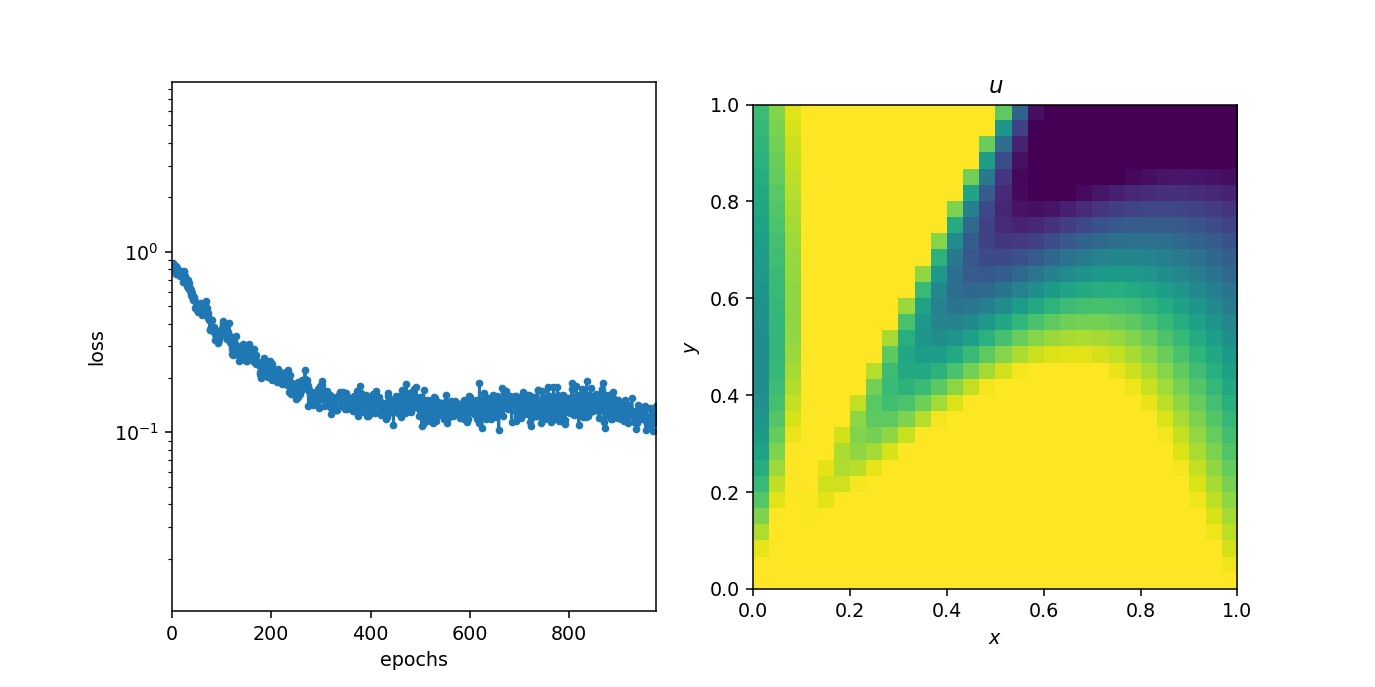

C:\Users\Bart de Koning\Anaconda3\lib\site-packages\ipykernel_launcher.py:184: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.


No convergence after 999 epochs


In [6]:
NN = PINN(random_sampling     = True,
          hidden_layer_widths = np.array([40,40,40]),
          N                   = 30)

NN.fit(tf_epochs     = 1000,
       plot_interval = 25,
       eps           = 1e-6)